<a href="https://colab.research.google.com/github/denizstij/Bitgrit_NFT_Price_Prediction/blob/main/Bitgrit_NFT_Price_Prediction6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import datetime

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder


In [ ]:
pd.set_option('display.width', 1000)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
dataset_path='/content/drive/MyDrive/Colab Notebooks/BritGritNFTPrices/dataset/'

In [ ]:
def seed_everything(seed=55):
    random.seed(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
MY_SEED=55
#MAX_SALE=1200
MAX_SALE=1
seed_everything(MY_SEED)

# Load Data

In [ ]:
df_cols=pd.read_csv(dataset_path+'collections.csv')
df_cols_stats=pd.read_csv(dataset_path+'collections_twitter_stats.csv')
df_all_train=pd.read_csv(dataset_path+'nfts_train.csv')
df_submission=pd.read_csv(dataset_path+'submission_format.csv')
df_nfts_predict=pd.read_csv(dataset_path+'nfts_predict.csv')

In [ ]:
def my_norm(x):
  #return np.log(x+1e-6)  
  return x /MAX_SALE

def inv_my_norm(x, is_tf=True):
  #return tf.exp(x) if is_tf else np.exp(np.nan_to_num(x,nan=0.0,posinf=0,neginf=0))
  return x* MAX_SALE

In [ ]:
#df_all_train['last_sale_price'].map(my_norm).map(lambda x:inv_my_norm(x, is_tf=False)).hist()
#np.log(1e-6)

In [ ]:
df_cols['seller_fees']=df_cols['seller_fees']/10000
df_cols['platform_fees']=df_cols['platform_fees']/10000

df_all_train['last_sale_price']=df_all_train['last_sale_price'] 
df_all_train['last_sale_price']=df_all_train['last_sale_price'].map(my_norm) #np.log(df_all_train['last_sale_price'])
HUBER_DELTA=df_all_train['last_sale_price'].mean()+3*df_all_train['last_sale_price'].std()

In [ ]:
df_cols['creation_date']=df_cols['creation_date'].map(lambda x: np.int32(x.replace('-','')))
df_cols['verification_status']=df_cols['verification_status'].astype(str)
df_cols['contract_type']=df_cols['contract_type'].astype(str)

df_all_train['last_sale_date']=df_all_train['last_sale_date'].map(lambda x: np.int32(x.replace('-','')))
df_nfts_predict['last_sale_date']=df_nfts_predict['last_sale_date'].map(lambda x: np.int32(x.replace('-','')))

In [ ]:
df_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           48 non-null     int64  
 1   collection_id        48 non-null     int64  
 2   total_supply         48 non-null     int64  
 3   creation_date        48 non-null     int32  
 4   verification_status  48 non-null     object 
 5   n_of_traits          48 non-null     int64  
 6   contract_type        48 non-null     object 
 7   seller_fees          46 non-null     float64
 8   platform_fees        48 non-null     float64
 9   openrarity_enabled   48 non-null     bool   
 10  has_website          48 non-null     bool   
 11  has_own_twitter      48 non-null     bool   
 12  has_discord          48 non-null     bool   
 13  has_medium           48 non-null     bool   
dtypes: bool(5), float64(2), int32(1), int64(4), object(2)
memory usage: 3.5+ KB


In [ ]:
df_cols.describe(include='all')

,Unnamed: 0,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
count,48.00,48.000000,48.000000,48.000000,48,48.000000,48,46.000000,4.800000e+01,48,48,48,48,48
unique,NaN,NaN,NaN,NaN,2,NaN,2,NaN,NaN,2,1,1,2,2
top,NaN,NaN,NaN,NaN,verified,NaN,own,NaN,NaN,False,False,True,True,False
freq,NaN,NaN,NaN,NaN,29,NaN,31,NaN,NaN,35,48,48,37,41
mean,23.50,30.333333,10760.979167,202155.729167,NaN,12.083333,NaN,0.071196,2.500000e-02,NaN,NaN,NaN,NaN,NaN
std,14.00,18.062932,9524.450152,49.038734,NaN,11.741603,NaN,0.024363,3.506162e-18,NaN,NaN,NaN,NaN,NaN
min,0.00,0.000000,1.000000,202101.000000,NaN,0.000000,NaN,0.020000,2.500000e-02,NaN,NaN,NaN,NaN,NaN
25%,11.75,14.750000,5541.000000,202108.000000,NaN,8.000000,NaN,0.050000,2.500000e-02,NaN,NaN,NaN,NaN,NaN
50%,23.50,30.500000,9555.000000,202156.500000,NaN,9.500000,NaN,0.075000,2.500000e-02,NaN,NaN,NaN,NaN,NaN
75%,35.25,45.250000,10000.000000,202204.000000,NaN,14.000000,NaN,0.090000,2.500000e-02,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_cols_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         48 non-null     int64  
 1   collection_id      48 non-null     int64  
 2   n_tweets_in_range  48 non-null     int64  
 3   avg_likes          48 non-null     float64
 4   avg_replies        48 non-null     float64
 5   avg_retweets       48 non-null     float64
 6   min_likes          48 non-null     int64  
 7   min_replies        48 non-null     int64  
 8   min_retweets       48 non-null     int64  
 9   max_likes          48 non-null     int64  
 10  max_replies        48 non-null     int64  
 11  max_retweets       48 non-null     int64  
dtypes: float64(3), int64(9)
memory usage: 4.6 KB


In [ ]:
df_cols_stats.describe()

,Unnamed: 0,collection_id,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,23.50,30.333333,43.250000,106.612882,21.821623,52.061582,20.458333,3.916667,8.291667,331.020833,98.041667,208.895833
std,14.00,18.062932,120.698058,188.034103,55.518648,91.257491,54.476604,10.771976,13.639677,786.673646,373.930586,468.414857
min,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.75,14.750000,4.750000,7.423289,0.887821,2.913973,0.000000,0.000000,0.000000,18.750000,6.000000,12.000000
50%,23.50,30.500000,11.500000,13.500000,4.114286,11.384211,0.000000,0.000000,1.000000,82.000000,17.500000,52.500000
75%,35.25,45.250000,26.000000,90.295455,9.111111,64.418280,3.750000,0.500000,7.500000,300.500000,70.250000,173.250000
max,47.00,60.000000,668.000000,707.875000,353.400000,442.000000,236.000000,52.000000,46.000000,5079.000000,2601.000000,2990.000000


In [ ]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309910 entries, 0 to 309909
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         309910 non-null  int64  
 1   nft_id               309910 non-null  int64  
 2   collection_id        309910 non-null  int64  
 3   rarity_score         309910 non-null  float64
 4   openrarity_score     80480 non-null   float64
 5   openrarity_rank      80480 non-null   float64
 6   openrarity_max_rank  80480 non-null   float64
 7   last_sale_date       309910 non-null  int32  
 8   last_sale_price      309910 non-null  float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 20.1 MB


In [ ]:
df_nfts_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181214 entries, 0 to 181213
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         181214 non-null  int64  
 1   nft_id               181214 non-null  int64  
 2   collection_id        181214 non-null  int64  
 3   rarity_score         181214 non-null  float64
 4   openrarity_score     38626 non-null   float64
 5   openrarity_rank      38626 non-null   float64
 6   openrarity_max_rank  38626 non-null   float64
 7   last_sale_date       181214 non-null  int32  
dtypes: float64(4), int32(1), int64(3)
memory usage: 10.4 MB


In [ ]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_index     50 non-null     int64  
 1   last_sale_price  50 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes


In [ ]:
set(df_nfts_predict.collection_id.values).intersection(set(df_all_train.collection_id.values))

set()

In [ ]:
df_submission.describe()

,global_index,last_sale_price
count,50.00000,50.000000
mean,24.50000,0.617073
std,14.57738,0.600778
min,0.00000,0.022996
25%,12.25000,0.205264
50%,24.50000,0.338147
75%,36.75000,0.920657
max,49.00000,2.266743


In [ ]:
df_nfts_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181214 entries, 0 to 181213
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         181214 non-null  int64  
 1   nft_id               181214 non-null  int64  
 2   collection_id        181214 non-null  int64  
 3   rarity_score         181214 non-null  float64
 4   openrarity_score     38626 non-null   float64
 5   openrarity_rank      38626 non-null   float64
 6   openrarity_max_rank  38626 non-null   float64
 7   last_sale_date       181214 non-null  int32  
dtypes: float64(4), int32(1), int64(3)
memory usage: 10.4 MB


In [ ]:
df_nfts_predict.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
count,181214.000000,181214.000000,181214.000000,181214.000000,38626.000000,38626.000000,38626.000000,181214.000000
mean,309791.155888,11445.662471,28.762866,232.415184,1.000000,4372.867628,8741.760731,202204.358532
std,167228.382814,11585.749965,15.321820,1392.046522,0.159457,2857.568048,2300.558399,17.554032
min,0.000000,0.000000,2.000000,0.000000,0.601661,1.000000,3332.000000,202102.000000
25%,231959.250000,3235.250000,22.000000,129.334538,0.880993,1925.000000,9854.000000,202206.000000
50%,287356.500000,7108.500000,35.000000,178.813158,0.982769,3989.000000,9999.000000,202208.000000
75%,459554.750000,16220.000000,39.000000,263.697190,1.086070,6767.000000,10000.000000,202209.000000
max,618141.000000,48256.000000,53.000000,152922.000000,2.561688,10000.000000,10000.000000,202211.000000


In [ ]:
df_all_train.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,309910.000000,309910.000000,309910.000000,309910.000000,80480.000000,80480.000000,80480.000000,309910.000000,3.099100e+05
mean,317003.207947,6738.162024,30.507160,1437.092531,1.000000,5630.164737,11255.829672,202192.401129,2.162269e+00
std,173138.765569,5977.542096,18.331668,4303.585892,0.152825,3812.126968,3452.713804,34.436556,1.275132e+01
min,21928.000000,0.000000,0.000000,1.000000,0.626738,1.000000,5555.000000,202103.000000,6.485360e-08
25%,174892.250000,2453.000000,13.000000,106.587184,0.906820,2515.750000,9928.000000,202202.000000,4.077085e-03
50%,341467.500000,5138.000000,34.000000,170.797030,0.978289,5030.000000,10000.000000,202207.000000,8.103344e-03
75%,493626.750000,8720.750000,46.000000,289.614129,1.059866,8207.250000,15000.000000,202209.000000,3.252062e-01
max,590227.000000,29898.000000,60.000000,90354.072248,3.663833,15555.000000,15555.000000,202211.000000,1.024002e+03


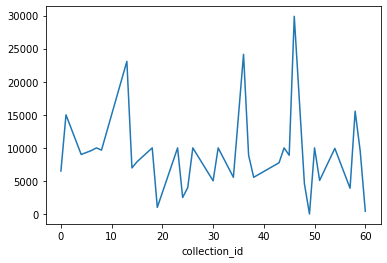

In [ ]:
df_all_train.groupby('collection_id')['collection_id'].count().plot()

In [ ]:
def plot_corr(df, describe, figsize=(4,4)):
  plt.figure(figsize =figsize)
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype = bool))
  sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6)
  title=f'Correlation of {describe} Variables'
  plt.title(title)
  plt.show()


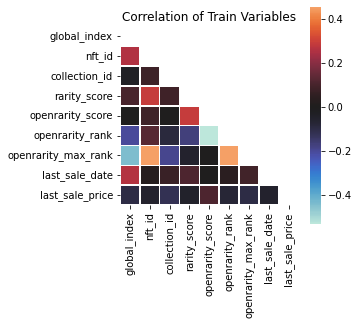

In [ ]:
plot_corr(df_all_train,'Train')

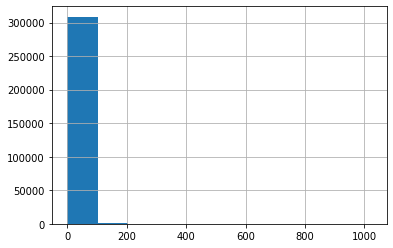

In [ ]:
df_all_train.last_sale_price.hist()

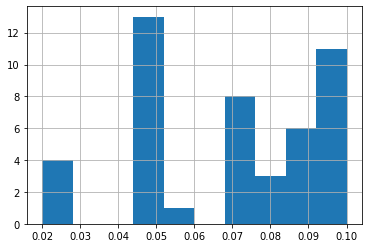

In [ ]:
df_cols.seller_fees.hist()

In [ ]:
df_all_train[df_all_train.collection_id.isin([49,0,38,37,59,19,26])].describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,41453.000000,41453.000000,41453.000000,41453.000000,14443.000000,14443.00000,14443.000000,41453.000000,4.145300e+04
mean,293070.699009,4142.983403,33.289919,140.056423,1.000000,3801.52586,7582.076923,202199.045521,8.104070e-01
std,170076.589033,2650.743844,18.684191,233.573074,0.132693,2384.36402,1602.600498,26.797274,6.423811e+00
min,21928.000000,0.000000,0.000000,1.000000,0.770374,1.00000,5555.000000,202104.000000,1.261076e-07
25%,175071.000000,1872.000000,26.000000,52.442926,0.931205,1804.50000,5555.000000,202205.000000,4.547653e-03
50%,215432.000000,3945.000000,37.000000,108.716551,0.990835,3611.00000,8849.000000,202207.000000,9.035782e-03
75%,322712.000000,6133.000000,38.000000,161.446023,1.050099,5416.50000,8849.000000,202209.000000,3.508993e-01
max,562664.000000,9999.000000,59.000000,9793.201352,3.663833,8849.00000,8849.000000,202211.000000,4.134943e+02


In [ ]:
df_all_train[~df_all_train.collection_id.isin([49,0,38,37,59,19,26])].describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,268457.000000,268457.000000,268457.000000,268457.000000,66037.000000,66037.000000,66037.000000,268457.000000,2.684570e+05
mean,320698.676097,7138.888917,30.077469,1637.370556,1.000000,6030.107667,12059.318791,202191.375155,2.371013e+00
std,173312.800242,6242.022048,18.238862,4590.468484,0.156885,3946.652814,3220.157346,35.358747,1.345383e+01
min,32621.000000,0.000000,1.000000,6.086957,0.626738,1.000000,5555.000000,202103.000000,6.485360e-08
25%,126682.000000,2567.000000,13.000000,115.935029,0.904555,2752.000000,9999.000000,202202.000000,4.013937e-03
50%,360470.000000,5436.000000,34.000000,179.105017,0.973403,5504.000000,10000.000000,202206.000000,7.975547e-03
75%,493990.000000,9269.000000,46.000000,319.059293,1.062781,8795.000000,15000.000000,202209.000000,3.131162e-01
max,590227.000000,29898.000000,60.000000,90354.072248,3.162588,15555.000000,15555.000000,202211.000000,1.024002e+03


# Create CV test for training 

In [ ]:
gs = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=MY_SEED)
train_ix, valid_ix = next(gs.split(df_all_train, groups=df_all_train.collection_id))

In [ ]:
df_train_raw=df_all_train.loc[train_ix,]


In [ ]:
df_valid_raw=df_all_train.loc[valid_ix,]

## Feature Engineering

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

class CategoricalTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.enc_vs=OneHotEncoder(drop='first',sparse=False, dtype=np.int8)
        self.enc_ct=OneHotEncoder(drop='first',sparse=False, dtype=np.int8)

        #self.labelEncoder_vs=LabelEncoder() # verification_status_encoded
        #self.labelEncoder_ct=LabelEncoder() # contract_type

    def fit(self, df, y=None):            
        self.enc_vs.fit(df['verification_status'].values.reshape((-1,1)))
        self.enc_ct.fit(df['contract_type'].values.reshape((-1,1)))               

        return self    

    def transform(self, df, y=None):
        self.feature_names=['last_sale_date_month','last_sale_date_year']          
        self.feature_names.extend(df.columns.values)     

        print(f'starting categorical feature with input shape: {df.shape}')
        df['verification_status']=self.enc_vs.transform(df['verification_status'].values.reshape((-1,1)))[:,0]
        df['contract_type']=self.enc_ct.transform(df['contract_type'].values.reshape((-1,1)))[:,0]
        df['last_sale_date_year']=df['last_sale_date']//100-2021
        df['creation_date']=df['creation_date']//100-2021
        df['last_sale_date_month']=df['last_sale_date']%100        
        df['openrarity_enabled']=df['openrarity_enabled'].astype("int")
        df['has_website']=df['has_website'].astype("int")
        df['has_own_twitter']=df['has_own_twitter'].astype("int")
        df['has_discord']=df['has_discord'].astype("int")
        df['has_medium']=df['has_medium'].astype("int")
        
        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [ ]:
class FeatureTransformers(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, df, y=None):    
        self.avg_avg_likes=df['avg_likes'].mean()                
        self.avg_avg_replies=df['avg_replies'].mean()                
        self.avg_avg_retweets=df['avg_retweets'].mean()                
        self.avg_fee=(df['seller_fees']+df['platform_fees']).mean()    

        return self    

    def transform(self, df, y=None):
        self.feature_names=['shelf_duration','openrarity_ratio',
                            'inverse_total_supply','ratio_avg_likes','ratio_avg_replies','ratio_avg_retweets',
                            'total_avg_likes','total_avg_twitter_activity', 'total_fee','ratio_avg_fee']            
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting feature with input shape: {df.shape}')
        df['shelf_duration']=df['last_sale_date']-df['creation_date']
        df['openrarity_ratio']=df['openrarity_rank']/df['openrarity_max_rank']      
        df['inverse_total_supply']=1/df['total_supply']
        df['ratio_avg_likes']=df['avg_likes']/self.avg_avg_likes
        df['ratio_avg_replies']=df['avg_replies']/self.avg_avg_replies
        df['ratio_avg_retweets']=df['avg_retweets']/self.avg_avg_retweets
        df['total_avg_likes']=df['avg_retweets']*df['n_tweets_in_range']
        df['total_avg_twitter_activity']=df['avg_likes']+df['avg_retweets']+df['avg_replies']
        df['total_fee']=df['seller_fees']+df['platform_fees']
        df['ratio_avg_fee']=df['total_fee']/self.avg_fee

        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [ ]:
class AvgPriceTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, df, y=None):   


        self.last_sale_year_avg_price=df.groupby('last_sale_date_year')['last_sale_price'].mean().rename('last_sale_price_year_avg')
        self.last_sale_year_std_price=df.groupby('last_sale_date_year')['last_sale_price'].std().rename('last_sale_price_year_std')
        self.last_sale_year_min_price=df.groupby('last_sale_date_year')['last_sale_price'].min().rename('last_sale_price_year_min')
        self.last_sale_year_max_price=df.groupby('last_sale_date_year')['last_sale_price'].max().rename('last_sale_price_year_max')

        self.last_sale_month_avg_price=df.groupby('last_sale_date_month')['last_sale_price'].mean().rename('last_sale_price_month_avg')
        self.last_sale_month_std_price=df.groupby('last_sale_date_month')['last_sale_price'].std().rename('last_sale_price_month_std')

        self.shelf_life_avg_price=df.groupby('shelf_duration')['last_sale_price'].mean().rename('last_sale_price_shelf_life_avg')
        self.shelf_life_std_price=df.groupby('shelf_duration')['last_sale_price'].std().rename('last_sale_price_shelf_life_std')
        self.shelf_life_min_price=df.groupby('shelf_duration')['last_sale_price'].min().rename('last_sale_price_shelf_life_min')
        self.shelf_life_max_price=df.groupby('shelf_duration')['last_sale_price'].max().rename('last_sale_price_shelf_life_max')

        self.last_sale_year_month_avg_price=df.groupby('last_sale_date')['last_sale_price'].mean().rename('last_sale_price_avg')
        self.last_sale_year_month_std_price=df.groupby('last_sale_date')['last_sale_price'].std().rename('last_sale_price_std')
        self.last_sale_year_month_min_price=df.groupby('last_sale_date')['last_sale_price'].min().rename('last_sale_price_min')
        self.last_sale_year_month_max_price=df.groupby('last_sale_date')['last_sale_price'].max().rename('last_sale_price_max')

        self.avg_like_by_collection=df.groupby('collection_id')['avg_likes'].mean().rename('avg_like_by_collection')
        self.avg_twitter_activity_by_collection=df.groupby('collection_id')['total_avg_twitter_activity'].mean().rename('avg_twitter_activity_by_collection')
        self.avg_seller_fees_by_collection=df.groupby('collection_id')['seller_fees'].mean().rename('avg_seller_fees_by_collection')
        self.avg_total_supply_by_collection=df.groupby('collection_id')['total_supply'].mean().rename('avg_total_supply_by_collection')
        

        return self    

    def transform(self, df, y=None):
        self.feature_names=['last_sale_price_shelf_life_avg','last_sale_price_shelf_life_std','last_sale_price_shelf_life_min','last_sale_price_shelf_life_max',
                            'last_sale_price_year_avg', 'last_sale_price_year_std','last_sale_price_year_min','last_sale_price_year_max',
                            'last_sale_price_month_avg','last_sale_price_month_std', 'last_sale_price_avg', 'last_sale_price_std', 'last_sale_price_min','last_sale_price_max',
                            'avg_like_by_collection','avg_twitter_activity_by_collection','avg_seller_fees_by_collection','avg_total_supply_by_collection']            

        self.feature_names.extend(df.columns.values)     

        print(f'starting avg price feature with input shape: {df.shape}')
        
        df=df.merge(self.last_sale_year_month_avg_price,on='last_sale_date', how='left')
        df=df.merge(self.last_sale_year_month_std_price,on='last_sale_date', how='left')
        df=df.merge(self.last_sale_year_month_min_price,on='last_sale_date', how='left')
        df=df.merge(self.last_sale_year_month_max_price,on='last_sale_date', how='left')
        
        df=df.merge(self.last_sale_year_avg_price,on='last_sale_date_year', how='left')
        df=df.merge(self.last_sale_year_std_price,on='last_sale_date_year', how='left')
        df=df.merge(self.last_sale_year_min_price,on='last_sale_date_year', how='left')
        df=df.merge(self.last_sale_year_max_price,on='last_sale_date_year', how='left')

        df=df.merge(self.last_sale_month_avg_price,on='last_sale_date_month', how='left')
        df=df.merge(self.last_sale_month_std_price,on='last_sale_date_month', how='left')

        df=df.merge(self.shelf_life_avg_price,on='shelf_duration', how='left')
        df=df.merge(self.shelf_life_std_price,on='shelf_duration', how='left')
        df=df.merge(self.shelf_life_min_price,on='shelf_duration', how='left')
        df=df.merge(self.shelf_life_max_price,on='shelf_duration', how='left')
      
        df=df.merge(self.avg_like_by_collection,on='collection_id', how='left')
        df=df.merge(self.avg_twitter_activity_by_collection,on='collection_id', how='left')
        df=df.merge(self.avg_seller_fees_by_collection,on='collection_id', how='left')
        df=df.merge(self.avg_total_supply_by_collection,on='collection_id', how='left')
      

        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [ ]:
class FillNAImputer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                                    
        print(f'starting fill na imputer with input shape:  {df.shape}')                        
        # first fill zero values with NA 
        df.fillna(0,inplace=True)
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [ ]:
def createPreprocessing():
    preprocessing=make_pipeline(FeatureTransformers(),                                
                                CategoricalTransformer(),
                                AvgPriceTransformer(),
                                FillNAImputer(),
                                verbose=True)
    return preprocessing
preprocessing=createPreprocessing()
preprocessing_all=createPreprocessing()

In [ ]:
num_features=['total_avg_twitter_activity','total_avg_likes','ratio_avg_likes','ratio_avg_replies','ratio_avg_retweets','inverse_total_supply', 
              'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'total_supply','n_of_traits', 
              'n_tweets_in_range', 'avg_likes', 'avg_replies', 'avg_retweets', 'min_likes', 'min_replies', 'min_retweets', 'max_likes', 'max_replies','max_retweets',
              'shelf_duration','openrarity_ratio', 'last_sale_price_shelf_life_avg','last_sale_price_shelf_life_std','last_sale_price_shelf_life_min','last_sale_price_shelf_life_max',
              'last_sale_price_year_avg', 'last_sale_price_year_std','last_sale_price_year_min','last_sale_price_year_max',
              'last_sale_price_avg', 'last_sale_price_std', 'last_sale_price_min','last_sale_price_max',
              'avg_like_by_collection','avg_twitter_activity_by_collection','avg_seller_fees_by_collection','avg_total_supply_by_collection']

#num_features=['rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'total_supply','n_of_traits', 
#              'n_tweets_in_range', 'avg_likes', 'avg_replies', 'avg_retweets', 'min_likes', 'min_replies', 'min_retweets', 'max_likes', 'max_replies','max_retweets']

##cat_features= ['collection_id','verification_status','contract_type','openrarity_enabled', 'has_website','has_own_twitter', 'has_discord', 'has_medium','creation_date','last_sale_date']

cat_features= ['collection_id','verification_status','contract_type','has_website','openrarity_enabled','has_own_twitter','has_discord','has_medium','creation_date','last_sale_date_year','last_sale_date_month']
target_feature='last_sale_price'
all_column_names= num_features + cat_features

In [ ]:
df_train=df_train_raw.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_processed=preprocessing.fit_transform(df_train.copy())
df_train_label=df_train_processed[target_feature].copy()
df_train_processed.drop([target_feature,'Unnamed: 0_x'],axis=1,inplace=True)
df_train_processed.describe(include='all')

starting feature with input shape: (270911, 33)
[Pipeline]  (step 1 of 4) Processing featuretransformers, total=   0.1s
starting categorical feature with input shape: (270911, 43)
[Pipeline]  (step 2 of 4) Processing categoricaltransformer, total=   0.2s
starting avg price feature with input shape: (270911, 45)
[Pipeline]  (step 3 of 4) Processing avgpricetransformer, total=   1.5s
starting fill na imputer with input shape:  (270911, 63)
[Pipeline] ..... (step 4 of 4) Processing fillnaimputer, total=   0.0s


,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_month_avg,last_sale_price_month_std,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,avg_like_by_collection,avg_twitter_activity_by_collection,avg_seller_fees_by_collection,avg_total_supply_by_collection,last_sale_date_month,last_sale_date_year,shelf_duration,openrarity_ratio,inverse_total_supply,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,total_avg_likes,total_avg_twitter_activity,total_fee,ratio_avg_fee,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
count,270911.000000,270911.000000,2.709110e+05,270911.000000,270911.000000,270911.000000,2.709110e+05,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,2.709110e+05,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,2.709110e+05,270911.000000,270911.0,270911.0,270911.00000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000
mean,0.996501,4.000521,2.123193e-06,160.133220,0.996501,4.526572,1.056614e-07,401.915065,0.996501,4.123341,0.996501,3.661115,1.836857e-06,159.729192,82.886508,143.767150,0.060072,13925.269269,7.131139,0.858171,41.242142,0.130153,0.000111,1.000000,1.000000,1.000000,541.011771,143.767150,0.082055,0.879322,313011.868983,7005.080237,31.997682,1613.169411,0.260163,1488.019250,2974.737722,202192.948252,13925.269269,0.454027,0.625187,10.889192,0.552591,0.060072,2.500000e-02,0.260163,0.0,1.0,0.73832,0.114831,24.762627,17.260739,82.886508,20.912914,39.967727,10.127307,2.258052,5.013499,335.764834,120.056347,194.241072
std,0.693551,2.137429,1.659254e-05,127.617314,0.089590,0.744713,1.003804e-07,4.707345,0.843726,1.827376,0.940011,2.601321,5.727143e-05,137.697709,161.062093,296.261781,0.032683,8334.964228,3.122525,0.348875,46.770084,0.264333,0.001925,1.943164,3.145946,2.167695,1257.661744,296.261781,0.038691,0.414622,169789.962619,6257.409496,17.851230,4568.883455,0.446006,3207.724628,5351.582374,33.822928,8334.964228,0.497883,0.484076,5.115975,0.497227,0.032683,1.387781e-17,0.438724,0.0,0.0,0.43955,0.318819,13.843448,28.677184,161.062093,65.790897,86.637841,29.494869,8.211830,9.227290,955.556053,474.914520,555.325729
min,0.004883,0.000000,6.485360e-08,0.008039,0.960079,4.223822,6.485360e-08,400.001379,0.409719,2.324424,0.042940,0.048546,6.485360e-08,0.108211,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,-8.000000,0.000000,0.000033,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,21928.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,202103.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.500000e-02,0.000000,0.0,1.0,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.312359,2.113278,4.108946e-07,72.000679,0.960079,4.223822,6.485360e-08,400.001379,0.417171,2.914958,0.332075,1.414726,2.838022e-07,43.006384,2.000000,13.055556,0.050000,8888.000000,4.000000,1.000000,1.000000,0.000000,0.000043,0.024129,0.009563

In [ ]:
#df_train[df_train.creation_date>df_train.last_sale_date]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270911 entries, 0 to 270910
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         270911 non-null  int64  
 1   nft_id               270911 non-null  int64  
 2   collection_id        270911 non-null  int64  
 3   rarity_score         270911 non-null  float64
 4   openrarity_score     70481 non-null   float64
 5   openrarity_rank      70481 non-null   float64
 6   openrarity_max_rank  70481 non-null   float64
 7   last_sale_date       270911 non-null  int32  
 8   last_sale_price      270911 non-null  float64
 9   Unnamed: 0_x         270911 non-null  int64  
 10  total_supply         270911 non-null  int64  
 11  creation_date        270911 non-null  int32  
 12  verification_status  270911 non-null  object 
 13  n_of_traits          270911 non-null  int64  
 14  contract_type        270911 non-null  object 
 15  seller_fees      

In [ ]:
pd.isnull(df_train_processed).sum(axis=0)

last_sale_price_shelf_life_avg    0
last_sale_price_shelf_life_std    0
last_sale_price_shelf_life_min    0
last_sale_price_shelf_life_max    0
last_sale_price_year_avg          0
                                 ..
min_replies                       0
min_retweets                      0
max_likes                         0
max_replies                       0
max_retweets                      0
Length: 61, dtype: int64

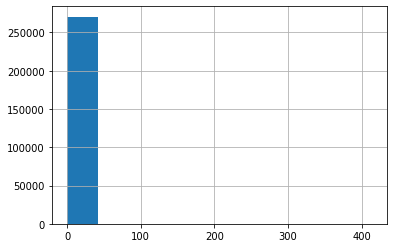

In [ ]:
df_train_label.hist()

In [ ]:
df_valid=df_valid_raw.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_valid_processed=preprocessing.transform(df_valid)
df_valid_label=df_valid_processed[target_feature].copy()
df_valid_processed.drop([target_feature,'Unnamed: 0_x'],axis=1,inplace=True)
df_valid_processed

starting feature with input shape: (38999, 33)
starting categorical feature with input shape: (38999, 43)
starting avg price feature with input shape: (38999, 45)
starting fill na imputer with input shape:  (38999, 63)


,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_month_avg,last_sale_price_month_std,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,avg_like_by_collection,avg_twitter_activity_by_collection,avg_seller_fees_by_collection,avg_total_supply_by_collection,last_sale_date_month,last_sale_date_year,shelf_duration,openrarity_ratio,inverse_total_supply,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,total_avg_likes,total_avg_twitter_activity,total_fee,ratio_avg_fee,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,1.640477,5.719008,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,5,0,1,0.0,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116861,0,7,204.010980,0.0,0.0,0.0,202105,9998,0,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
1,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,1.640477,5.719008,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,5,0,1,0.0,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116862,1,7,182.480289,0.0,0.0,0.0,202105,9998,0,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
2,0.300481,3.079332,1.261076e-07,105.003970,1.216877,6.358433,3.525795e-07,413.494300,0.417171,2.324424,0.629498,3.718647,5.902306e-06,105.003970,0.0,0.0,0.0,0.0,11,0,7,0.0,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116863,2,7,221.312185,0.0,0.0,0.0,202111,9998,0,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
3,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,1.640477,5.719008,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,5,0,1,0.0,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116864,3,7,149.498840,0.0,0.0,0.0,202105,9998,0,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
4,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,1.640477,5.719008,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,5,0,1,0.0,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116865,4,7,268.527043,0.0,0.0,0.0,202105,9998,0,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.752649,3.446782,0.428641,2.855335,1.261076e-07,400.001379,0.0,0.0,0.0,0.0,8,1,6,0.0,0.000111,0.098374,0.0423,0.028869,30.0,10.192308,0.115,1.232366,590223,8995,4,128.268841,0.0,0.0,0.0,202208,9000,1,0,8,0,0.090,0.025,0,0,1,0,0,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
38995,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.752649,3.446782,0.428641,2.855335,1.261076e-07,400.001379,0.0,0.0,0.0,0.0,8,1,6,0.0,0.000111,0.098374,0.0423,0.028869,30.0,10.192308,0.115,1.232366,590224,8996,4,152.040769,0.0,0.0,0.0,202208,9000,1,0,8,0,0.090,0.025,0,0,1,0,0,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
38996,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.752649,

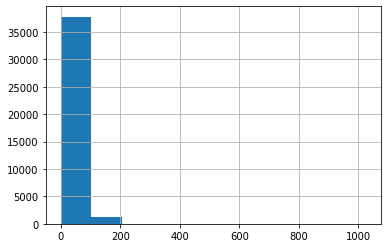

In [ ]:
df_valid_label.hist()

In [ ]:
df_train_all_merged=df_all_train.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_all_merged_label=df_train_all_merged[target_feature].copy()
#df_train_all_merged.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)
df_train_all_merged.columns


Index(['global_index', 'nft_id', 'collection_id', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'last_sale_date', 'last_sale_price', 'Unnamed: 0_x', 'total_supply', 'creation_date', 'verification_status', 'n_of_traits', 'contract_type', 'seller_fees', 'platform_fees', 'openrarity_enabled', 'has_website', 'has_own_twitter', 'has_discord', 'has_medium', 'Unnamed: 0_y', 'n_tweets_in_range', 'avg_likes', 'avg_replies', 'avg_retweets', 'min_likes', 'min_replies', 'min_retweets', 'max_likes', 'max_replies', 'max_retweets'], dtype='object')

In [ ]:
df_test_all_merged=df_nfts_predict.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_test_all_merged
#df_test_all_merged_label=df_test_all_merged[target_feature].copy()
#df_train_all_merged.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,Unnamed: 0_x,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,0,0,29,176.364208,NaN,NaN,NaN,202206,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
1,1,1,29,207.209228,NaN,NaN,NaN,202205,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
2,2,2,29,157.293414,NaN,NaN,NaN,202210,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
3,3,3,29,173.372185,NaN,NaN,NaN,202206,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
4,4,4,29,190.077584,NaN,NaN,NaN,202206,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181209,618137,7140,42,134.963415,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13
181210,618138,7141,42,128.686047,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13
181211,618139,7142,42,22134.000000,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13
181212,618140,7143,42,22134.000000,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13


In [ ]:
df_train_all_processed=df_all_train.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_all_processed_label=df_train_all_processed[target_feature].copy()
#df_train_all_processed.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)
#df_train_all_processed=preprocessing_all.fit_transform(df_train_all_processed.copy())
#df_train_all_processed

In [ ]:
df_valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38999 entries, 0 to 38998
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   last_sale_price_shelf_life_avg      38999 non-null  float64
 1   last_sale_price_shelf_life_std      38999 non-null  float64
 2   last_sale_price_shelf_life_min      38999 non-null  float64
 3   last_sale_price_shelf_life_max      38999 non-null  float64
 4   last_sale_price_year_avg            38999 non-null  float64
 5   last_sale_price_year_std            38999 non-null  float64
 6   last_sale_price_year_min            38999 non-null  float64
 7   last_sale_price_year_max            38999 non-null  float64
 8   last_sale_price_month_avg           38999 non-null  float64
 9   last_sale_price_month_std           38999 non-null  float64
 10  last_sale_price_avg                 38999 non-null  float64
 11  last_sale_price_std                 38999

In [ ]:
df_valid_processed[all_column_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38999 entries, 0 to 38998
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   total_avg_twitter_activity          38999 non-null  float64
 1   total_avg_likes                     38999 non-null  float64
 2   ratio_avg_likes                     38999 non-null  float64
 3   ratio_avg_replies                   38999 non-null  float64
 4   ratio_avg_retweets                  38999 non-null  float64
 5   inverse_total_supply                38999 non-null  float64
 6   rarity_score                        38999 non-null  float64
 7   openrarity_score                    38999 non-null  float64
 8   openrarity_rank                     38999 non-null  float64
 9   openrarity_max_rank                 38999 non-null  float64
 10  total_supply                        38999 non-null  int64  
 11  n_of_traits                         38999

In [ ]:
df_train_processed[all_column_names]

,total_avg_twitter_activity,total_avg_likes,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,inverse_total_supply,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,n_of_traits,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,shelf_duration,openrarity_ratio,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,avg_like_by_collection,avg_twitter_activity_by_collection,avg_seller_fees_by_collection,avg_total_supply_by_collection,verification_status,contract_type,has_website,openrarity_enabled,has_own_twitter,has_discord,has_medium,creation_date,last_sale_date_year,last_sale_date_month
0,257.193548,1889.0,2.267772,0.396421,1.524617,1.000000,2.000000,0.0,0.0,0.0,1,2,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,7,0.0,0.300481,3.079332,1.261076e-07,105.003970,0.960079,4.223822,6.485360e-08,400.001379,0.332075,1.414726,6.485360e-08,43.006384,187.967742,257.193548,0.10,1.0,1,1,0,0,1,1,0,1,1,11
1,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,97.077216,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,0.0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,2.491572,5.319862,2.164313e-06,130.005079,133.181818,201.818182,0.05,8888.0,1,1,0,0,1,1,0,0,0,8
2,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,139.453086,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,101,0.0,0.630831,4.731466,1.489020e-06,400.001379,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,133.181818,201.818182,0.05,8888.0,1,1,0,0,1,1,0,0,1,8
3,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,127.753445,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,0.0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,2.491572,5.319862,2.164313e-06,130.005079,133.181818,201.818182,0.05,8888.0,1,1,0,0,1,1,0,0,0,8
4,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,112.315719,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,102,0.0,0.223820,1.284130,6.485360e-08,33.007089,0.960079,4.223822,6.485360e-08,400.001379,0.256652,1.322104,2.838022e-07,25.502344,133.181818,201.818182,0.05,8888.0,1,1,0,0,1,1,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270906,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,401.063769,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,0.300481,3.079332,1.261076e-07,105.003970,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,8.075000,14.775000,0.09,10000.0,0,0,0,0,1,0,0,1,1,8
270907,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,148.726179,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,0.300481,3.079332,1.261076e-07,105.003970,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,8.075000,14.775000,0.09,10000.0,0,0,0,0,1,0,0,1,1,8
270908,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,196.309829,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,0.300481,3.079332,1.261076e-07,105.003970,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,8.075000,14.775000,0.09,10000.0,0,0,0,0,1,0,0,1,1,8
270909,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,117.435698,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,0.300481,3.079332,1.261076e-07,105.003970,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,8.075000,14.775000,0.09

In [ ]:
df_valid_processed[all_column_names]

,total_avg_twitter_activity,total_avg_likes,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,inverse_total_supply,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,n_of_traits,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,shelf_duration,openrarity_ratio,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,avg_like_by_collection,avg_twitter_activity_by_collection,avg_seller_fees_by_collection,avg_total_supply_by_collection,verification_status,contract_type,has_website,openrarity_enabled,has_own_twitter,has_discord,has_medium,creation_date,last_sale_date_year,last_sale_date_month
0,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,204.010980,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,1,1,0,0,1,1,0,0,0,5
1,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,182.480289,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,1,1,0,0,1,1,0,0,0,5
2,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,221.312185,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,7,0.0,0.300481,3.079332,1.261076e-07,105.003970,1.216877,6.358433,3.525795e-07,413.494300,0.629498,3.718647,5.902306e-06,105.003970,0.0,0.0,0.0,0.0,1,1,0,0,1,1,0,0,0,11
3,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,149.498840,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,1,1,0,0,1,1,0,0,0,5
4,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,268.527043,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,1.142344,4.211920,2.962572e-06,130.005079,1.216877,6.358433,3.525795e-07,413.494300,0.737054,0.592495,3.357847e-03,1.684732,0.0,0.0,0.0,0.0,1,1,0,0,1,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,128.268841,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,1,8
38995,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,152.040769,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,1,8
38996,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,178.734807,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,1,8
38997,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,130.974464,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,0.727428,8.431723,2.422092e-06,413.494300,0.960079,4.223822,6.485360e-08,400.001379,0.428641,2.855335,1.261076e-07,400.001379,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,1,8


In [ ]:
df_train_processed[all_column_names].apply(lambda x: x.unique())

total_avg_twitter_activity            [257.19354838709677, 201.81818181818184, 8.947...
total_avg_likes                       [1889.0, 607.0, 170.0, 2399.0, 82.0, 16.0, 24....
ratio_avg_likes                       [2.2677724848600023, 1.6067973134455125, 0.0, ...
ratio_avg_replies                     [0.39642119820245936, 0.6433606145570866, 0.0,...
ratio_avg_retweets                    [1.5246171847329024, 1.380659394827423, 0.2238...
inverse_total_supply                  [1.0, 0.0001125112511251125, 0.000100030009002...
rarity_score                          [2.0, 97.07721623225166, 139.45308602172497, 1...
openrarity_score                      [0.0, 0.986535021319271, 1.003833199964582, 0....
openrarity_rank                       [0.0, 5814.0, 4386.0, 6549.0, 3497.0, 4926.0, ...
openrarity_max_rank                   [0.0, 9928.0, 15555.0, 5555.0, 8849.0, 15000.0...
total_supply                          [1, 8888, 9997, 5022, 6501, 12505, 7993, 9998,...
n_of_traits                     

In [ ]:
df_train_label.describe()

count    2.709110e+05
mean     9.965007e-01
std      4.588282e+00
min      6.485360e-08
25%      4.073473e-03
50%      8.083610e-03
75%      3.363717e-01
max      4.134943e+02
Name: last_sale_price, dtype: float64

In [ ]:
df_valid_label.describe()

count    3.899900e+04
mean     1.026041e+01
std      3.272384e+01
min      6.608277e-08
25%      4.107917e-03
50%      8.244784e-03
75%      2.762810e-01
max      1.024002e+03
Name: last_sale_price, dtype: float64

In [ ]:
df_valid_processed[all_column_names].apply(lambda x: x.unique())

total_avg_twitter_activity            [111.83333333333331, 391.66666666666663, 10.19...
total_avg_likes                         [1341.9999999999998, 309.0, 29.999999999999993]
ratio_avg_likes                           [0.0, 2.742706130937027, 0.09837362391585547]
ratio_avg_replies                       [0.0, 2.9327970357287008, 0.042299957246087025]
ratio_avg_retweets                    [2.7980908822683164, 2.5770792328492096, 0.028...
inverse_total_supply                  [0.00010002000400080016, 0.0001000100010001000...
rarity_score                          [204.0109803902137, 182.48028907683928, 221.31...
openrarity_score                      [0.0, 0.845854681585512, 0.922150504780118, 1....
openrarity_rank                       [0.0, 9532.0, 6731.0, 2395.0, 2525.0, 217.0, 8...
openrarity_max_rank                                                       [0.0, 9999.0]
total_supply                                                  [9998, 9999, 10000, 9000]
n_of_traits                     

In [ ]:
df_train_label

0         1.266732
1         1.200357
2         3.180572
3         3.502910
4         4.009567
            ...   
270906    0.005700
270907    0.004271
270908    0.003694
270909    0.007942
270910    0.000732
Name: last_sale_price, Length: 270911, dtype: float64

# Model Training with LightGBM and DART

In [ ]:
class ExpRMSEMetric(tf.keras.metrics.Metric):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.mse=tf.keras.metrics.MeanSquaredError()

  def reset_state(self):
    self.mse.reset_state()    

  def update_state(self,y_true, y_pred, sample_weight=None):
    self.mse.update_state(inv_my_norm(y_true),inv_my_norm(y_pred))    
  
  def result(self):
    mean_squared_error=self.mse.result()
    rmse=tf.sqrt(mean_squared_error)
    res=tf.exp(-rmse/10)
    return res


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredError

def create_exp_rmse_score(mult=-1, log=False):
  def exp_rmse_score_fn(y_true, y_hat):    
      mse=MeanSquaredError()
      mse_res=mse(y_true,y_hat)
      rmse=K.sqrt(mse_res)
      res=K.exp(mult*rmse/10)
      if log:
        print(f"Tensor mse_res:{mse_res} rmse: {rmse} res: {res} mult:{mult}")
      return res
  return exp_rmse_score_fn

def lgb_exp_rmse_score(y_true, y_hat):        

    res=exp_rmse_score(y_true,y_hat)
    #print(f"res: {res}")
    return 'exp_rmse', res, True

def exp_rmse_score(y_true, y_hat):            
    rmse=mean_squared_error (inv_my_norm(y_true,is_tf=False), inv_my_norm(y_hat, is_tf=False), squared=False)        
    res=np.exp(-rmse/10)

    print(f"Numpy rmse: {rmse} res: {res}")

    return res

In [ ]:
import tensorflow as tf
def create_mlp_regressor(lr0=0.001,num_iter=1000):  

  tf.random.set_seed(MY_SEED)

  #regulazier=tf.keras.regularizers.L1L2(0.0,0.8)  #  kernel_regularizer=regulazier,
  #regulazier=tf.keras.regularizers.L2(0)
  #activation= tf.nn.leaky_relu)
  #activation=tf.keras.layers.LeakyReLU(alpha=0.3)
  activation='relu'

  num_input_layer= tf.keras.layers.Input(name='num',shape=(len(num_features),))
  num_normalized_layer=tf.keras.layers.Normalization(name='num_norm')
  cat_layer=tf.keras.layers.Input(name='cat',shape=(len(cat_features),))
  input_layer=tf.keras.layers.concatenate([num_normalized_layer(num_input_layer),cat_layer])

  layer1=tf.keras.layers.Dense(80,activation=activation,kernel_initializer='he_normal') (input_layer) 
  layer2=tf.keras.layers.Dense(100,activation=activation,kernel_initializer='he_normal') (layer1) 
  layer3=tf.keras.layers.Dense(120,activation=activation,kernel_initializer='he_normal')(layer2)
  
  output_layer=tf.keras.layers.Dense(1) (layer3)
  model= tf.keras.models.Model(inputs=[num_input_layer,cat_layer],outputs=[output_layer])

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr0)  
  #optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)  
  #optimizer = tf.keras.optimizers.SGD(learning_rate=lr0,nesterov=True, momentum=0.9)
  #loss=tf.keras.losses.Huber(delta=6)
  #loss=tf.keras.losses.MeanSquaredLogarithmicError()    
  #loss=tf.keras.losses.LogCosh()
  #loss= tf.keras.losses.MeanAbsolutePercentageError()
  #loss=tf.keras.losses.MeanAbsoluteError()
  loss='mse'

  model.compile(loss=loss, optimizer=optimizer, metrics= [tf.keras.metrics.RootMeanSquaredError(), ExpRMSEMetric() ])
  fit_params={
      'epochs':num_iter
  }

  return model, fit_params, num_normalized_layer


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 num (InputLayer)               [(None, 40)]         0           []                               
                                                                                                  
 num_norm (Normalization)       (None, 40)           81          ['num[0][0]']                    
                                                                                                  
 cat (InputLayer)               [(None, 11)]         0           []                               
                                                                                                  
 concatenate_10 (Concatenate)   (None, 51)           0           ['num_norm[0][0]',               
                                                                  'cat[0][0]']             

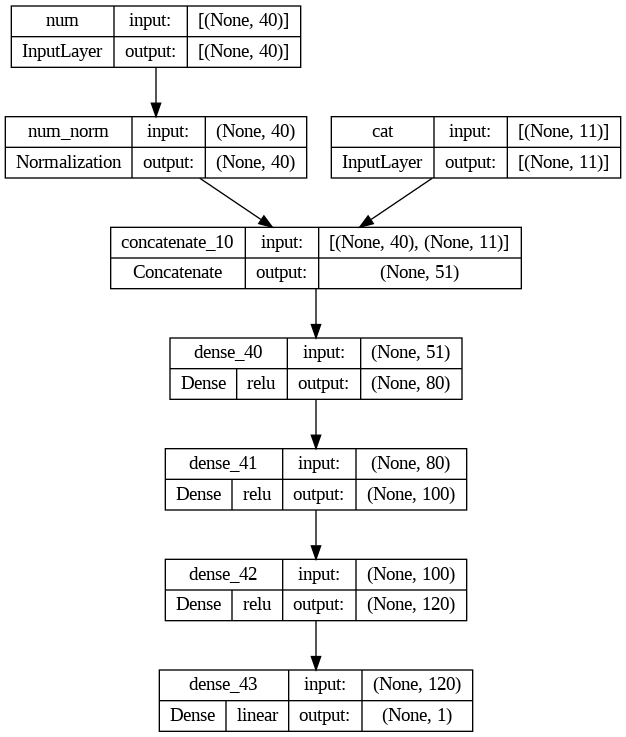

In [ ]:
regressor, fit_params, norm_layer=create_mlp_regressor(0.01,5)
print(regressor.summary())
tf.keras.utils.plot_model(regressor,  show_shapes=True, show_layer_activations=True)

In [ ]:
from sklearn.model_selection import KFold
# CV 

def apply_cross_validation(lr0=0.001,num_iter=100,cv=5):    
    seed_everything()        

    threshold=5  
    df_train_all_merged_filtered =df_train_all_merged[df_train_all_merged_label<threshold].copy()
    df_train_all_merged_label_filtered=df_train_all_merged_label[df_train_all_merged_label<threshold]
    
    #df=df_train_all_merged_filtered.copy()
    #df_label=df_train_all_merged_label_filtered.copy()
    #df_valid=df_train_all_merged.copy()
    #df_valid_label=df_train_all_merged_label.copy()

    df=df_train_all_merged.copy()
    df_label=df_train_all_merged_label.copy()
    df_valid=df_train_all_merged_filtered.copy()
    df_valid_label=df_train_all_merged_label_filtered.copy()

    pred_results=np.zeros(len(df))
    y_true=np.zeros(len(df))
    fold_results=[]
    
    res=None
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=MY_SEED)   
    for i, (train_index, test_index) in enumerate(kf.split(df)):            
      print(f"fold: {i} MAX_SALE: {MAX_SALE}")
      df_train_processed=df.iloc[train_index].copy()
      df_valid_processed=df.iloc[test_index].copy()
      df_train_processed_label=df_label.iloc[train_index]
      df_valid_processed_label=df_label.iloc[test_index]

      preprocessing=createPreprocessing()      
      df_train_processed=preprocessing.fit_transform(df_train_processed)
      df_valid_processed=preprocessing.transform(df_valid_processed)
      df_all_valid_processed=preprocessing.transform(df_valid.copy())      

      regressor, fit_params, norm_layer=create_mlp_regressor(lr0,num_iter)     

                      
      fit_params['validation_data']=((df_valid_processed[num_features].values,df_valid_processed[cat_features].values),
                                      df_valid_processed_label.values)
      
      monitor="val_root_mean_squared_error"
      lr_scdeduler=tf.keras.callbacks.ReduceLROnPlateau(factor=0.75, patience=20, monitor=monitor)           

      #lr_scdeduler=tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
      #early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor="val_root_mean_squared_error", patience=50, restore_best_weights=True)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor=monitor, patience=50, restore_best_weights=True)

      batch_size=df_train_processed.shape[0]
      norm_layer.adapt(df_train_processed[num_features])
      history=regressor.fit((df_train_processed[num_features].to_numpy(),df_train_processed[cat_features].to_numpy()),
                            df_train_processed_label.to_numpy(),  **fit_params, callbacks=[early_stopping_cb, lr_scdeduler], batch_size=batch_size)  
      eval_results=regressor.evaluate((df_all_valid_processed[num_features].to_numpy(), df_all_valid_processed[cat_features].to_numpy()),
                                      df_valid_label.to_numpy())
      

      predict_hat=regressor.predict((df_valid_processed[num_features].to_numpy(),df_valid_processed[cat_features].to_numpy()))
      
      print(f" predict_hat shape: {predict_hat.shape}")
      predict_hat=predict_hat[:,0]
      pred_results[test_index]=predict_hat
      y_true[test_index]=df_valid_processed_label

      scr=exp_rmse_score(df_valid_processed_label,predict_hat)     
      fold_results.append(scr)
      print(f" fold: {i} exp_rmse_score: {scr}  eval_results: {eval_results} fold_results: {fold_results}  ")
      #predict_hat[:,1]
      #break;
    
    final_scr=exp_rmse_score(y_true, pred_results)
    print(f" final exp_rmse_score: {final_scr}")

    return regressor, pred_results, y_true, final_scr, fold_results, df_valid_processed[all_column_names],  df_valid_processed_label

regressor,pred_results, y_true, final_scr, fold_results, df_v, v_label=apply_cross_validation(lr0=0.01,num_iter=500,cv=5)
final_scr

fold: 0 MAX_SALE: 1
starting feature with input shape: (247928, 33)
[Pipeline]  (step 1 of 4) Processing featuretransformers, total=   0.1s
starting categorical feature with input shape: (247928, 43)
[Pipeline]  (step 2 of 4) Processing categoricaltransformer, total=   0.2s
starting avg price feature with input shape: (247928, 45)
[Pipeline]  (step 3 of 4) Processing avgpricetransformer, total=   1.4s
starting fill na imputer with input shape:  (247928, 63)
[Pipeline] ..... (step 4 of 4) Processing fillnaimputer, total=   0.0s
starting feature with input shape: (61982, 33)
starting categorical feature with input shape: (61982, 43)
starting avg price feature with input shape: (61982, 45)
starting fill na imputer with input shape:  (61982, 63)
starting feature with input shape: (291753, 33)
starting categorical feature with input shape: (291753, 43)
starting avg price feature with input shape: (291753, 45)
starting fill na imputer with input shape:  (291753, 63)
Epoch 1/500
1/1 [========

KeyboardInterrupt: ignored

In [ ]:
df_train_processed=df_train_all_merged.copy()     
df_train_all_processed_label=df_train_all_merged_label.values

preprocessing=createPreprocessing()
df_train_all_processed=preprocessing.fit_transform(df_train_processed)

starting feature with input shape: (309910, 33)
[Pipeline]  (step 1 of 4) Processing featuretransformers, total=   0.1s
starting categorical feature with input shape: (309910, 43)
[Pipeline]  (step 2 of 4) Processing categoricaltransformer, total=   0.3s
starting avg price feature with input shape: (309910, 45)
[Pipeline]  (step 3 of 4) Processing avgpricetransformer, total=   1.7s
starting fill na imputer with input shape:  (309910, 63)
[Pipeline] ..... (step 4 of 4) Processing fillnaimputer, total=   0.0s


In [ ]:
#threshold=100000
threshold=5
df_train_all_processed_filtered=df_train_all_processed[df_train_all_processed_label<threshold]
df_train_all_processed_label_filtered=df_train_all_processed_label[df_train_all_processed_label<threshold]

In [ ]:
df=df_train_all_processed_filtered
df_label=df_train_all_processed_label_filtered
df_valid=df_train_all_processed
df_valid_label=df_train_all_processed_label

#df=df_train_all_processed
#df_label=df_train_all_processed_label
#df_valid=df_train_all_processed_filtered
#df_valid_label=df_train_all_processed_label_filtered

In [ ]:
regressor, fit_params, norm_layer=create_mlp_regressor(lr0=0.01,num_iter=250)
lr_scdeduler=tf.keras.callbacks.ReduceLROnPlateau(factor=0.75, patience=20, monitor="root_mean_squared_error")     
early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor="root_mean_squared_error", patience=50, restore_best_weights=True)

fit_params['validation_data']=((df_valid[num_features].values, df_valid[cat_features].values),df_valid_label)

norm_layer.adapt(df_train_all_processed[num_features].to_numpy())
history=regressor.fit((df[num_features].to_numpy(), df[cat_features].to_numpy()), df_label,  **fit_params, callbacks=[early_stopping_cb,lr_scdeduler], batch_size=df_label.shape[0])  

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 8.4658 - root_mean_squared_error: 2.9096 - exp_rmse_metric_16: 0.7475 - val_loss: 1809.7455 - val_root_mean_squared_error: 42.5411 - val_exp_rmse_metric_16: 0.0142 - lr: 0.0100
Epoch 2/250
1/1 [==============================] - 0s 314ms/step - loss: 1760.9192 - root_mean_squared_error: 41.9633 - exp_rmse_metric_16: 0.0151 - val_loss: 267.7535 - val_root_mean_squared_error: 16.3632 - val_exp_rmse_metric_16: 0.1947 - lr: 0.0100
Epoch 3/250
1/1 [==============================] - 0s 301ms/step - loss: 127.4561 - root_mean_squared_error: 11.2896 - exp_rmse_metric_16: 0.3234 - val_loss: 281.4803 - val_root_mean_squared_error: 16.7774 - val_exp_rmse_metric_16: 0.1868 - lr: 0.0100
Epoch 4/250
1/1 [==============================] - 0s 293ms/step - loss: 100.2423 - root_mean_squared_error: 10.0121 - exp_rmse_metric_16: 0.3674 - val_loss: 425.4357 - val_root_mean_squared_error: 20.6261 - val_exp_rmse_metric_16: 0.1271 - lr: 0.0

In [ ]:
#regressor, fit_params=create_catboost_regressor(2000)
#regressor, fit_params=create_lgb_regressor(100)
#regressor.fit(df_train_all_processed[all_column_names], df_train_all_processed_label,**fit_params)

In [ ]:
final_train_pred_results=regressor.predict((df_train_all_processed[num_features],df_train_all_processed[cat_features]))

9685/9685 [==============================] - 13s 1ms/step


In [ ]:
np.histogram(final_train_pred_results)

(array([  1219, 184335,  67531,  15604,  18289,   5573,   6595,   7224,
          2716,    824]),
 array([-0.51794314, -0.16846967,  0.18100381,  0.5304773 ,  0.87995076,
         1.2294242 ,  1.5788977 ,  1.9283712 ,  2.2778447 ,  2.6273181 ,
         2.9767916 ], dtype=float32))

In [ ]:
np.histogram(final_train_pred_results)

(array([  1219, 184335,  67531,  15604,  18289,   5573,   6595,   7224,
          2716,    824]),
 array([-0.51794314, -0.16846967,  0.18100381,  0.5304773 ,  0.87995076,
         1.2294242 ,  1.5788977 ,  1.9283712 ,  2.2778447 ,  2.6273181 ,
         2.9767916 ], dtype=float32))

In [ ]:
exp_rmse_score(final_train_pred_results, df_train_all_processed_label)

Numpy rmse: 12.836011844860677 res: 0.2770378375455428


0.2770378375455428

#Run Regressor on the test set

In [ ]:
df_test_all_merged=df_nfts_predict.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_test_all_processed = preprocessing.transform(df_test_all_merged)

starting feature with input shape: (181214, 32)
starting categorical feature with input shape: (181214, 42)
starting avg price feature with input shape: (181214, 44)
starting fill na imputer with input shape:  (181214, 62)


In [ ]:
final_pred_results=regressor.predict((df_test_all_processed[num_features],df_test_all_processed[cat_features]))

5663/5663 [==============================] - 8s 1ms/step


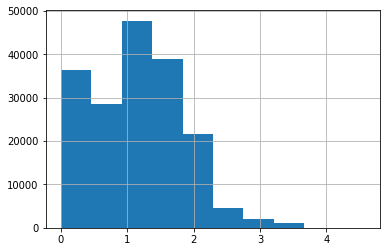

In [ ]:
df_final_results=df_test_all_processed['global_index'].to_frame()
df_final_results['last_sale_price']=np.where(final_pred_results>0,final_pred_results,0)
#df_final_results['last_sale_price']=final_pred_results
df_final_results.last_sale_price.hist()

In [ ]:
current_time =datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
df_final_results.to_csv(f'submission_{current_time}.csv', index=False)

In [ ]:
df_submission.head()

,global_index,last_sale_price
0,0,0.234588
1,1,0.243322
2,2,0.231398
3,3,0.150778
4,4,2.015249


In [ ]:
df_submission.describe()

,global_index,last_sale_price
count,50.00000,50.000000
mean,24.50000,0.617073
std,14.57738,0.600778
min,0.00000,0.022996
25%,12.25000,0.205264
50%,24.50000,0.338147
75%,36.75000,0.920657
max,49.00000,2.266743


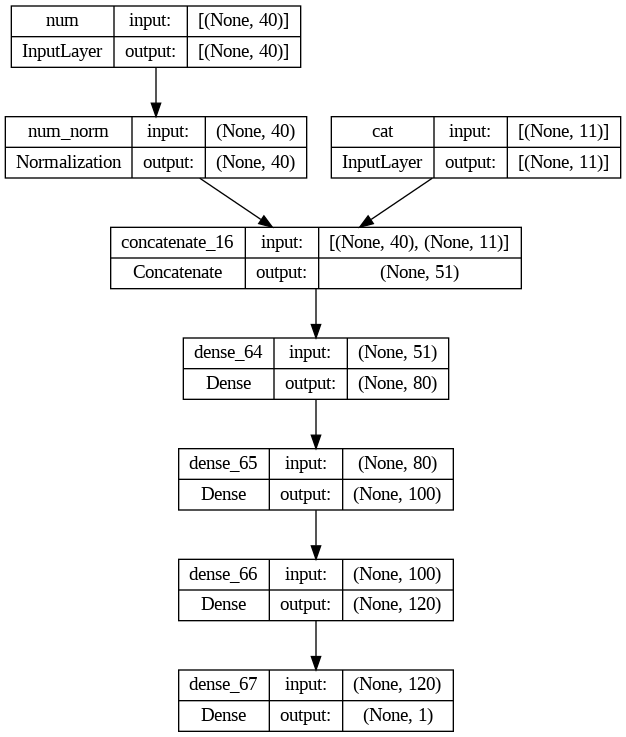

In [ ]:
tf.keras.utils.plot_model(regressor, show_shapes=True)